In [1]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Exploritory Data Analysis on Amazon Reviews
#Function that Parses the Data from the Zipfile
def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
#Function that converts Zipfile to Dataframe      
def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

sports_outdoors = convert_to_DF('reviews_Sports_and_Outdoors_5.json.gz')
print('Dataset size: {:,} words'.format(len(sports_outdoors)))

Dataset size: 296,337 words


In [2]:
#The first 3 results of the Dataframe
sports_outdoors[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"


In [4]:
#Convert the Date of each review into a clock time
sports_outdoors["reviewTime"] = pd.to_datetime(sports_outdoors["reviewTime"])

#Organize columns by relevance regarding reviews
sports_outdoors = sports_outdoors[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime', 'unixReviewTime']]
sports_outdoors.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200


In [5]:
#Last 3 Reviews
sports_outdoors.tail(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
296334,B00LFPS0CY,"""Great Water Bottle For Hot Day""......","This Hydracentials Sporty 25 OZ, double insula...",5.0,ASKZO80Z1RKTR,Robin Lee,"[0, 0]",2014-07-21,1405900800
296335,B00LFPS0CY,A pretty impressive water bottle. Best I've s...,As usual I received this item free in exchange...,5.0,APRNS6DB68LLV,"Rob Slaven ""slavenrm@gmail. com""","[1, 1]",2014-07-21,1405900800
296336,B00LFPS0CY,"""Cool"" Bottle!",Hydracentials insulated 25 oz water bottle.Thi...,5.0,A3UJRNI8UR4871,"Wulfstan ""wulfstan""","[2, 2]",2014-07-15,1405382400


In [6]:
#Finding the number of reviews for Unique Products
products = sports_outdoors['overall'].groupby(sports_outdoors['asin']).count()
print("Number of Unique Products in the Sports & Outdoors Category = {}".format(products.count()))

Number of Unique Products in the Sports & Outdoors Category = 18357


In [10]:
#Top 20 Most reviewed Products
sorted_products = products.sort_values(ascending=False)
print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B001HBHNHE - has {}reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B001HBHNHE    1042
B001T7QJ9O     763
B000S5ODN2     647
B0010O748Q     513
B0000C50K3     427
B002ZYRV2E     401
B002OKWHVO     398
B000GCRWCG     393
B001HBHNHY     372
B0035L35A8     359
B004U8CP88     357
B001WJ577O     355
B004TNWD40     349
B006X9DLQM     344
B00178CS4K     343
B006QF3TW4     323
B003NFI092     309
B00200E0HM     307
B001949TKS     298
B000JZ7JM8     293
Name: overall, dtype: int64

Most Reviewed Product, B001HBHNHE - has 1042reviews.


In [11]:
#Top 20 Least reviewed Products
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[18337:], end='\n\n')
print('Least Reviewed Product (Sorted), B003Z6HUZE - has {}reviews.'.format(products.min()))

Bottom 20 Reviewed Products:

asin
B003VN1U7K    5
B003VZIWZQ    5
B00BFXAIEY    5
B000T1VZCW    5
B000TH4MMG    5
B003XDWY32    5
B000T29STI    5
B003WXR992    5
B003WXJOEA    5
B000TAADTO    5
B00BGI7R38    5
B003WHHXAS    5
B000TTR0JG    5
B003WHA1N4    5
B000TRKTUK    5
B000TTHVYA    5
B003WGUEEG    5
B000TTM3OI    5
B003WDTI78    5
B003Z6HUZE    5
Name: overall, dtype: int64

Least Reviewed Product (Sorted), B003Z6HUZE - has 5reviews.


In [12]:
#Cleaning up text data to get rid of uncessary punctuations
#Top 11 review comments
sports_outdoors['reviewText'][:11]

0     This came in on time and I am veru happy with ...
1     I had a factory Glock tool that I was using fo...
2     If you don't have a 3/32 punch or would like t...
3     This works no better than any 3/32 punch you w...
4     I purchased this thinking maybe I need a speci...
5     Needed this tool to really break down my G22, ...
6     If u don't have it .. Get it. All you need to ...
7     This light will no doubt capture the attention...
8     Light and laser torch work well, very bright. ...
9     Does everything it says it will do. I would li...
10    Very bright.  I would recommend this lite to a...
Name: reviewText, dtype: object

In [42]:
#Filtering out uncessary words and converting reviews into English
stops = stopwords.words('english')

#Function that splits up large text into small groups
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
        tokens = lemmatize(no_punc)
        return tokens

#Function that groups tenses of a word to fall under one word
def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma
    
reviews = sports_outdoors['reviewText'].apply(lambda x: tokenize(x))
reviews[:11]

0       [This]
1          [I]
2         [If]
3       [This]
4          [I]
5     [Needed]
6         [If]
7       [This]
8      [Light]
9       [Does]
10      [Very]
Name: reviewText, dtype: object

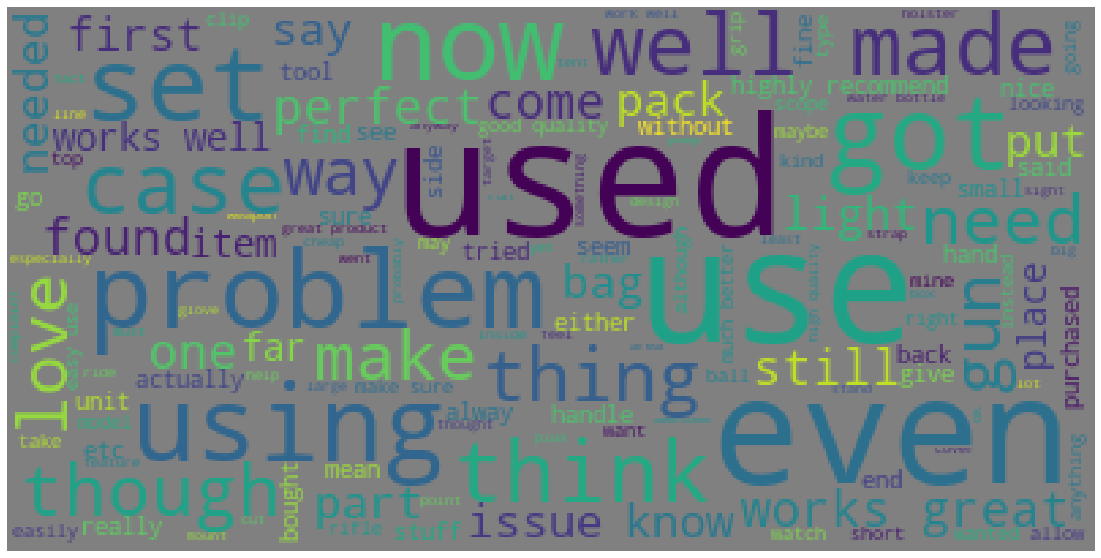

In [43]:
#Logistic Regression model that shows whether the most common used words in a review are positive or negative
#Word Cloud
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, relative_scaling=1).generate(''.join(sports_outdoors.reviewText))
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

In [44]:
#Top 3 reviews
sports_outdoors[:3]

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200


In [45]:
#Find star rating of each product
sports_outdoors['pos_neg'] = [1 if x > 3 else 0 for x in sports_outdoors.overall]
sports_outdoors.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400,1
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800,1
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200,1


In [47]:
#Train/Test Split to predict the amount of Positive and Negative Reviews
review_text = sports_outdoors["reviewText"]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sports_outdoors.reviewText, sports_outdoors.pos_neg, random_state=0)
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (222252,)
y_train shape: (222252,)

x_test shape: (74085,)
y_test shape: (74085,)



In [48]:
#Vectorization function that will turn the reviewer's text into a numerical value
#Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<222252x28733 sparse matrix of type '<class 'numpy.int64'>'
	with 12428687 stored elements in Compressed Sparse Row format>


In [49]:
#Number of features for how many terms were selected from the text
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 28733


In [51]:
#Test the model's accuracy
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

C:\Users\ugoch\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ugoch\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Mean cross-validation accuracy: 0.891


C:\Users\ugoch\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [53]:
#Accuracy of testing data
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
X_test = vectorizer.transform(x_test)
log_y_pred = logreg.predict(X_test)
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy: {:.3f}".format(logreg_score))

C:\Users\ugoch\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.890


In [54]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.901
Test set score: 0.890


In [56]:
#Confusion matrix to show the summary of the predicted results
from sklearn.metrics import confusion_matrix
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 4518  6416]
 [ 1734 61417]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


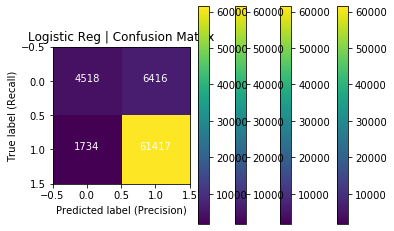

In [60]:
#Plot for the Confusion matrix
plt.imshow(log_cfm, interpolation='nearest')
for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],horizontalalignment="center",color="white")
    plt.ylabel('True label (Recall)')
    plt.xlabel('Predicted label (Precision)')
    plt.title('Logistic Reg | Confusion Matrix')
    plt.colorbar();

In [62]:
#Accuracy of the test
from sklearn.metrics import f1_score
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.938
